In [15]:
import requests
import json
import pandas as pd
from config import nyt_key
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
months = ["3","4","5","6","7"]
year = "2020"

publication_date = []
document_type = []
headline = []
abstract = []
snippet = []
lead_paragraph = []
keyword_1 = []
keyword_2 = []
keyword_3 = []

for month in months:
    base_url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={nyt_key}"
    response = requests.get(base_url).json()["response"]["docs"]
    for i in response:
        if len(i["keywords"]) >= 3:
            publication_date.append(i["pub_date"])
            document_type.append(i["document_type"])
            headline.append(i["headline"]["main"])
            abstract.append(i["abstract"])
            snippet.append(i["snippet"])
            lead_paragraph.append(i["lead_paragraph"])
            keyword_1.append(i["keywords"][0]["value"])
            keyword_2.append(i["keywords"][1]["value"])
            keyword_3.append(i["keywords"][2]["value"])

In [17]:
data = {
    "publication_date":publication_date,
    "document_type":document_type,
    "headline":headline,
    "abstract":abstract,
    "snippet":snippet,
    "lead_paragraph":lead_paragraph,
    "keyword_1":keyword_1,
    "keyword_2":keyword_2,
    "keyword_3":keyword_3,
}

In [18]:
df = pd.DataFrame(data)
print(len(df))
df.head()

29997


,publication_date,document_type,headline,abstract,snippet,lead_paragraph,keyword_1,keyword_2,keyword_3
0,2020-03-01T07:22:34+0000,article,"On ‘S.N.L.’, John Mulaney and Jake Gyllenhaal ...","Mulaney, the comic and former “S.N.L.” writer,...","Mulaney, the comic and former “S.N.L.” writer,...","The annual appearances of John Mulaney, who th...",Television,Saturday Night Live (TV Program),"Mulaney, John"
1,2020-03-01T11:51:43+0000,article,"What Comes Next, Joe Biden?",He needs to capitalize on his big South Caroli...,He needs to capitalize on his big South Caroli...,Finally! Four states and nearly two months int...,Presidential Election of 2020,Primaries and Caucuses,Democratic Party
2,2020-03-02T08:00:09+0000,article,"Feeling Robbed, the Dodgers Are ‘Working Angry’","They have won seven N.L. West titles in a row,...","They have won seven N.L. West titles in a row,...","GLENDALE, Ariz. — Alex Wood was the last pitch...",Baseball,Los Angeles Dodgers,Houston Astros
3,2020-03-02T08:00:11+0000,article,New York City Had One of Its Least Snowy Winte...,"There was almost no snow at all in February, l...","There was almost no snow at all in February, l...","On Feb. 1 in Central Park, children threw snow...",Snow and Snowstorms,New York City,Global Warming
4,2020-03-01T21:12:51+0000,article,"A Virus Spreads, Stocks Fall, and Democrats Se...",The president’s response to rising fears over ...,The president’s response to rising fears over ...,WASHINGTON — Democratic presidential candidate...,Coronavirus (2019-nCoV),Presidential Election of 2020,United States Economy


In [19]:
# getting total counts of keywords from entire data set including all months
keyword_count_1 = df.keyword_1.value_counts()[0:500]
keyword_count_2 = df.keyword_2.value_counts()[0:500]
keyword_count_3 = df.keyword_3.value_counts()[0:500]

# combine total keyword counts into new dataframe and display top 50 results
combined = pd.concat([keyword_count_1,keyword_count_2,keyword_count_3],axis=1).fillna(0)
combined = combined["keyword_1"] + combined["keyword_2"] + combined["keyword_3"]
top_keywords = combined.sort_values(ascending=False)[0:20]

Text(0.5, 1.0, '2020 Top NYT Keywords (March - July)')

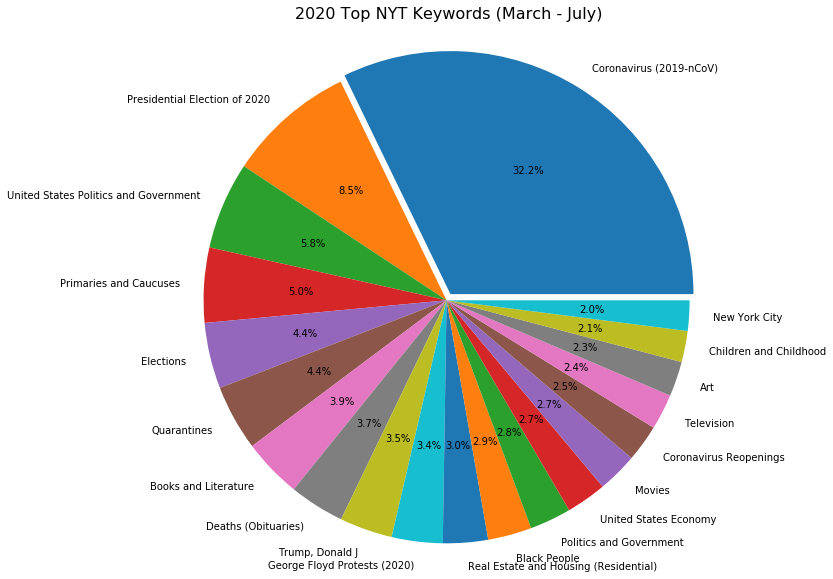

In [20]:
plt.figure(figsize=(13,10))
explode = (.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
plt.pie(top_keywords,explode=explode,labels=top_keywords.index,autopct="%1.1f%%")
plt.axis("equal")
plt.title(f"{year} Top NYT Keywords (March - July)",size=16)
# plt.savefig(f"Output/{year} Top NYT Keywords (March - July).png")

## Evaluating word mentions with the Natural Language Toolkit
* This code tokenizes all headlines, abstracts, lead_paragraphs and keywords into one large string
* All stopwords and words containing puncuation or numbers are dropped from the tokenized data
* The top 1000 words and their counts are displayed in dictionary format

In [21]:
# original dataframe
df = df.drop("snippet",axis=1)
df.head()

,publication_date,document_type,headline,abstract,lead_paragraph,keyword_1,keyword_2,keyword_3
0,2020-03-01T07:22:34+0000,article,"On ‘S.N.L.’, John Mulaney and Jake Gyllenhaal ...","Mulaney, the comic and former “S.N.L.” writer,...","The annual appearances of John Mulaney, who th...",Television,Saturday Night Live (TV Program),"Mulaney, John"
1,2020-03-01T11:51:43+0000,article,"What Comes Next, Joe Biden?",He needs to capitalize on his big South Caroli...,Finally! Four states and nearly two months int...,Presidential Election of 2020,Primaries and Caucuses,Democratic Party
2,2020-03-02T08:00:09+0000,article,"Feeling Robbed, the Dodgers Are ‘Working Angry’","They have won seven N.L. West titles in a row,...","GLENDALE, Ariz. — Alex Wood was the last pitch...",Baseball,Los Angeles Dodgers,Houston Astros
3,2020-03-02T08:00:11+0000,article,New York City Had One of Its Least Snowy Winte...,"There was almost no snow at all in February, l...","On Feb. 1 in Central Park, children threw snow...",Snow and Snowstorms,New York City,Global Warming
4,2020-03-01T21:12:51+0000,article,"A Virus Spreads, Stocks Fall, and Democrats Se...",The president’s response to rising fears over ...,WASHINGTON — Democratic presidential candidate...,Coronavirus (2019-nCoV),Presidential Election of 2020,United States Economy


In [22]:
# converting data points into one large string value
all_headline = df['headline'].str.lower().str.cat(sep=' ')
all_abstract = df['abstract'].str.lower().str.cat(sep=' ')
all_lead_paragraph = df['lead_paragraph'].str.lower().str.cat(sep=' ')
all_keywords = df['keyword_1'].str.lower().str.cat(sep=' ') + df['keyword_2'].str.lower().str.cat(sep=' ') + df['keyword_2'].str.lower().str.cat(sep=' ')
all_words = all_headline + all_abstract + all_lead_paragraph + all_keywords
words_count = all_words.split(sep=" ")
print(f"Total number of raw words: {len(words_count):,}")

Total number of raw words: 2,287,077


In [23]:
# natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# tokenizing the massive string value and filtering out all stopwords, puncuation and numbers
stop_words=set(stopwords.words('english'))
word_tokenize=word_tokenize(all_words)
alpha_word_tokenize=[word for word in word_tokenize if word.isalpha()]
filtered_tokenize=[word for word in alpha_word_tokenize if not word in stop_words]
print(f"Total number of tokenized words after filters applied: {len(filtered_tokenize):,}")

Total number of tokenized words after filters applied: 1,343,636


In [24]:
# creating dictionary with keys=keywords and values=number_of_keyword_mentions 
term_freq={}
for token in filtered_tokenize: 
    if token in term_freq: 
        term_freq[token]+=1
    else: 
        term_freq[token]=1

In [25]:
# getting the top 100 mentions of all headlines, abstracts, lead_paragraphs and keywords
import math
sort_freq=sorted(term_freq.items(), key=lambda x: x[1], reverse=True)
top_terms_freq=sort_freq[:1000]
top_terms_dict={}

for each_term_freq in top_terms_freq: 
    if type(each_term_freq[0])==tuple: 
        top_terms_dict[' '.join(each_term_freq[0])]=each_term_freq[1]
    else: 
        top_terms_dict[each_term_freq[0]]=each_term_freq[1]

### Top 1000 Words Used In NYT's Reporting (Mar/2020 - Jun/2020)

In [26]:
top_terms_dict

{'coronavirus': 23441,
 'new': 10477,
 'trump': 6844,
 'states': 5971,
 'pandemic': 5831,
 'people': 5363,
 'election': 5165,
 'united': 5135,
 'one': 5013,
 'president': 4633,
 'york': 4443,
 'presidential': 4321,
 'government': 4062,
 'said': 4026,
 'home': 3441,
 'city': 3396,
 'black': 3180,
 'world': 3152,
 'politics': 3085,
 'police': 3019,
 'like': 2969,
 'first': 2953,
 'two': 2903,
 'would': 2883,
 'time': 2875,
 'week': 2715,
 'washington': 2655,
 'many': 2631,
 'health': 2595,
 'us': 2574,
 'house': 2558,
 'state': 2536,
 'protests': 2508,
 'may': 2499,
 'deaths': 2491,
 'could': 2401,
 'country': 2382,
 'years': 2340,
 'life': 2288,
 'last': 2275,
 'virus': 2157,
 'even': 2122,
 'get': 2083,
 'biden': 2054,
 'day': 2001,
 'george': 1908,
 'times': 1904,
 'children': 1867,
 'public': 1854,
 'american': 1848,
 'back': 1837,
 'elections': 1794,
 'floyd': 1792,
 'died': 1784,
 'economy': 1765,
 'federal': 1757,
 'social': 1756,
 'national': 1743,
 'art': 1699,
 'year': 1674,
 '